This notebook provides exploratory visualisation of the observations density in space and time for the train, validation, and test datasets.

In [103]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from IPython.display import HTML
from matplotlib import animation
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
ROOT = Path("../../..")
DATA_DIR = ROOT / "data"

In [3]:
from_datetime_str = "1994-06-01"
to_datetime_str = "2025-08-01"

In [38]:
train_ds = xr.open_zarr(DATA_DIR / f"gdp_interp_clean_{from_datetime_str}_{to_datetime_str}_train.zarr")
val_ds = xr.open_zarr(DATA_DIR / f"gdp_interp_clean_{from_datetime_str}_{to_datetime_str}_val.zarr")
test_ds = xr.open_zarr(DATA_DIR / f"gdp_interp_clean_{from_datetime_str}_{to_datetime_str}_test.zarr")

In [77]:
print(f"Number of samples per dataset: train={len(train_ds.points)}, val={len(val_ds.points)}, test={len(test_ds.points)}")

Number of samples per dataset: train=43288886, val=14540603, test=14049608


In [96]:
bin_size = 1  # in degree

lon_edges = np.arange(-180, 180 + bin_size, bin_size)
lat_edges = np.arange(-90,  90 + bin_size, bin_size)

lon_centers = 0.5 * (lon_edges[:-1] + lon_edges[1:])
lat_centers = 0.5 * (lat_edges[:-1] + lat_edges[1:])

months = np.arange(1, 13)
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

R = 6371.0  # km

lat_rad = np.deg2rad(lat_edges)
lon_rad = np.deg2rad(lon_edges)

d_lon = np.diff(lon_rad)
d_sin_lat = np.diff(np.sin(lat_rad))
area = (R**2) * np.outer(d_lon, d_sin_lat)

In [90]:
area_da = xr.DataArray(area.T, coords=[lat_centers, lon_centers], dims=["lat", "lon"])

In [ ]:
def compute_density_2d(lon, lat):
    counts, _, _ = np.histogram2d(lon, lat, bins=[lon_edges, lat_edges])
    density = counts.T / area_da
    return density


def compute_monthly_density_2d(ds):
    lon = ds.lon.values
    lat = ds.lat.values
    month = ds.time.dt.month.values

    order = np.argsort(month)
    lon = lon[order]
    lat = lat[order]
    month = month[order]

    _, idx_start = np.unique(month, return_index=True)

    density_monthly = []
    for i, start in enumerate(idx_start):
        end = idx_start[i + 1] if i + 1 < len(idx_start) else len(month)
        density_monthly.append(compute_density_2d(lon[start:end], lat[start:end]).values)

    return xr.DataArray(
        np.stack(density_monthly, axis=0),
        coords={
            "month": months,
            "lat": area_da.lat,
            "lon": area_da.lon,
        },
        dims=["month", "lat", "lon"],
    )


def plot_observations_density(ds, label, vmin=1e-4, vmax=1, needs_compute=True):
    if needs_compute:
        density = compute_density_2d(ds.lon.values, ds.lat.values)
    else:
        density = ds

    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.Robinson()})
    
    im = density.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        norm=colors.LogNorm(),
        vmin=vmin,
        vmax=vmax,
        cmap=cmo.dense,
        add_colorbar=True,
        cbar_kwargs={
            "orientation": "horizontal",
            "pad": 0.025,
            "fraction": 0.05,
            "label": "Number of observations per km$^2$",
        },
    )

    ax.coastlines()
    ax.add_feature(cfeature.LAND, color="lightgrey")
    ax.set_title(label)

    fig.tight_layout()

    return fig, ax, im


def plot_annual_observations_density(ds, label):
    da = compute_monthly_density_2d(ds)

    fig, ax, im = plot_observations_density(da.isel(month=0), label, needs_compute=False)
    ax.set_title(label, loc="left")
    title = ax.set_title(f"{month_names[0]}")

    def update(frame):
        im.set_array(da.isel(month=frame).values.ravel())
        title.set_text(f"{month_names[frame]}")
        return im, title

    anim = animation.FuncAnimation(fig, update, frames=len(month_names), interval=400, blit=True, repeat=True)

    return HTML(anim.to_html5_video())


def plot_monthly_counts():
    fig, ax = plt.subplots()

    def monthly_counts(ds):
        return ds.time.groupby(ds.time.dt.month.compute()).count()

    for data, label in zip(
        [monthly_counts(train_ds), monthly_counts(val_ds), monthly_counts(test_ds)],
        ["Train", "Validation", "Test"],
    ):
        ax.plot(data["month"], data.values, marker="o", linestyle="-", label=f"{label} set")

    ax.set_xlabel("Month")
    ax.set_ylabel("Number of observations")
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names)
    ax.grid(True, alpha=0.3)

    ax.legend()

    fig.tight_layout()
    
    return fig, ax


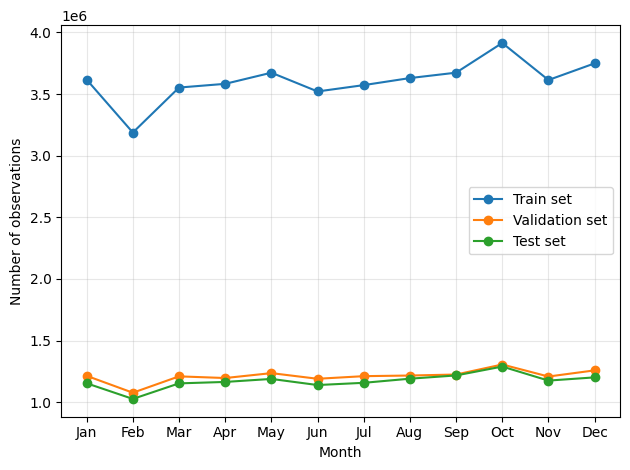

In [ ]:
fig, ax = plot_monthly_counts()
plt.show()

In [94]:
_, _, _ = plot_observations_density(train_ds, "Train set")
plt.show()

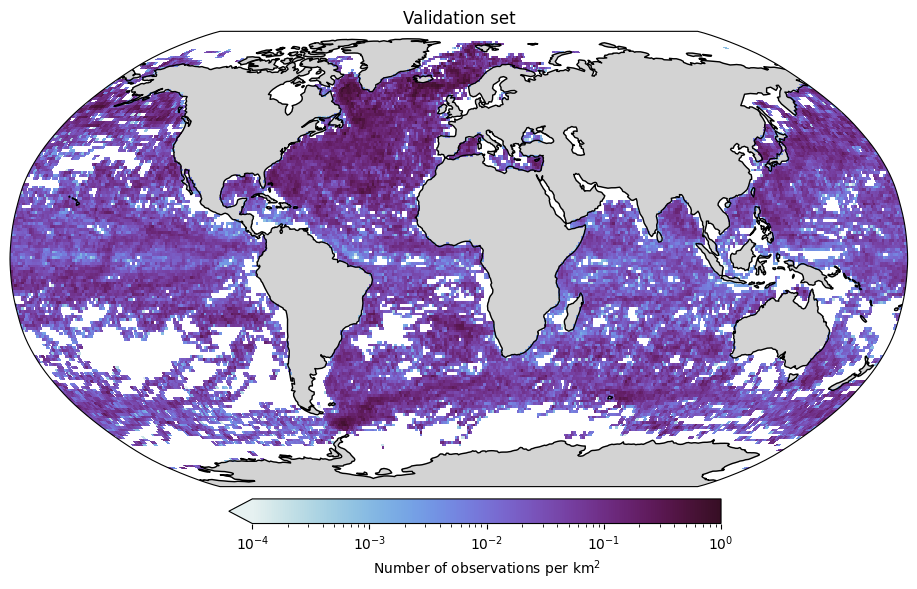

In [83]:
_, _, _ = plot_observations_density(val_ds, "Validation set")
plt.show()

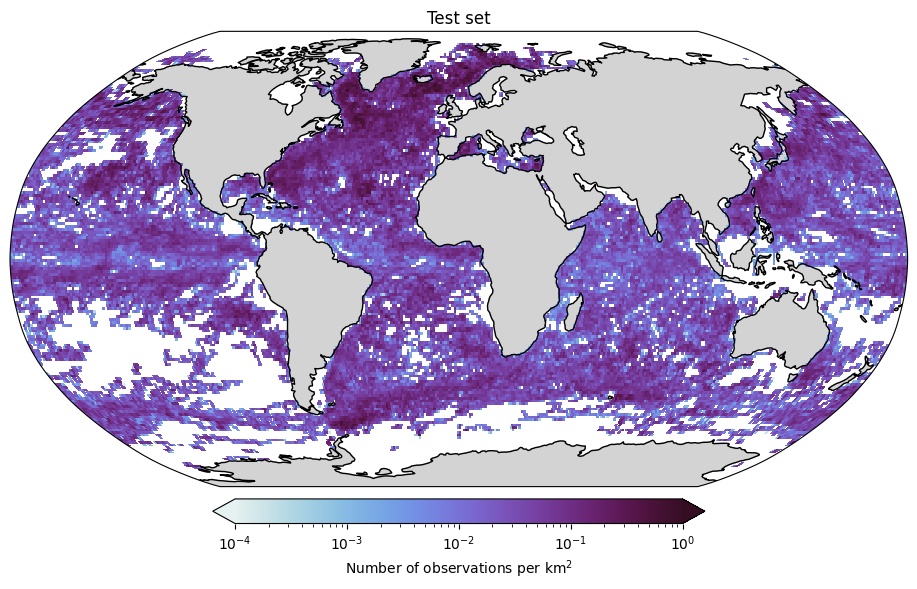

In [84]:
_, _, _ = plot_observations_density(test_ds, "Test set")
plt.show()

In [115]:
plt.ioff()
plot_annual_observations_density(train_ds, "Train set")

In [116]:
plt.ioff()
plot_annual_observations_density(val_ds, "Validation set")

In [117]:
plt.ioff()
plot_annual_observations_density(test_ds, "Test set")